Dans ce fichier, nous allons explorer les différentes pistes pour déterminer le modèle de machine learning optimal à utiliser. 

imports de librairies:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

chargement des données:

In [4]:
pressure = pd.read_table('valve-condition-server/data/PS2.txt', header=None)
flow = pd.read_table('valve-condition-server/data/FS1.txt', header = None)
profile = pd.read_table('valve-condition-server/data/profile.txt', header = None)
valve_condition = profile.iloc[:, 1].values

Présentation des données :
Entrée : deux vecteurs (flow et pressure) représentant respectivement le flux et la pression en fonction du temps.
Il s'agit de séries temporelles.

Sortie : valve_condition, une variable catégorielle ordinale prenant ses valeurs dans l'ensemble {73, 80, 90, 100}.

1) Régression linéaire sur l’ensemble des données
Pour commencer, nous allons examiner si une simple régression linéaire appliquée à l’ensemble des données permet d’obtenir de bons résultats.

MSE : 0.036662047967049034
R² : 0.9996643598453696


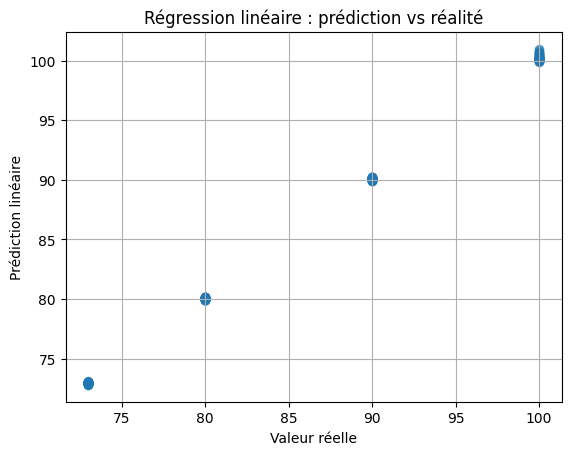

In [5]:
pressure.columns = [f'pressure_{i}' for i in range(pressure.shape[1])]
flow.columns = [f'flow_{i}' for i in range(flow.shape[1])]
X = pd.concat([pressure, flow], axis=1)
y = valve_condition

n_train = 2000
X_train = X.iloc[:n_train]
X_test = X.iloc[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE :", mean_squared_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeur réelle")
plt.ylabel("Prédiction linéaire")
plt.title("Régression linéaire : prédiction vs réalité")
plt.grid(True)
plt.show()

Nous obtenons de très bons résultats. Cependant, comme les données sont des séries temporelles, ce modèle manque de robustesse. En effet, une simple translation temporelle des variations (plus tôt ou plus tard dans la séquence) pourrait suffire à dégrader fortement les performances du modèle.

Dans notre cas, les bons résultats s’expliquent par le fait que les variations de flux et de pression se produisent globalement aux mêmes instants dans toutes les séquences. Or, cette régularité n’est pas garantie dans des situations réelles plus variées, ce qui limite la capacité de généralisation du modèle de régression linéaire.

2) Extraction de features
Une autre approche, plus adaptée au caractère temporel des données, consiste à extraire des features (caractéristiques) statistiques à partir des séries, telles que la moyenne, le minimum, le maximum ou encore l’écart-type

Cette méthode permet de mieux capturer le comportement global des signaux tout en étant moins sensible aux décalages temporels. En effet, plutôt que d’analyser les valeurs à chaque instant précis, elle résume l’information sous forme de descripteurs globaux ou locaux, ce qui offre une meilleure robustesse face à des variations dans le positionnement temporel des événements.

MSE : 0.03851309767959627
R² : 0.9996474135304145


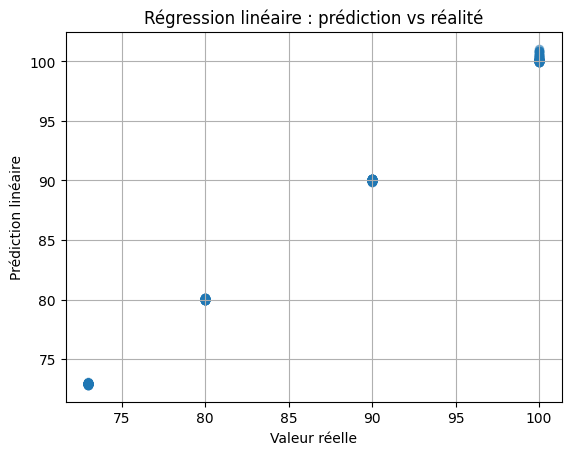

In [ ]:
def extract_features(signal: np.ndarray):
    features = [
        np.mean(signal),
        np.std(signal),
        np.min(signal),
        np.max(signal),
        skew(signal),
        kurtosis(signal),
        np.sum(signal**2),
    ]
    return features

def dataframe_to_features(data_name: str, df: pd.DataFrame):
    features_list = []
    for i, row in df.iterrows():
        features = extract_features(row.values)
        features_list.append(features)
    features_df = pd.DataFrame(
        features_list,
        columns=[
            data_name + "_mean", data_name + "_std", data_name + "_min", data_name + "_max", 
            data_name + "_skew", data_name + "_kurtosis", data_name + "_energy"
        ]
    )
    return features_df


valve_condition = profile.iloc[:, 1].values
pressure.columns = [f'pressure_{i}' for i in range(pressure.shape[1])]
flow.columns = [f'flow_{i}' for i in range(flow.shape[1])]
pressure_features = dataframe_to_features("pressure",pressure)
flow_feature = dataframe_to_features("flow",flow)
X = pd.concat([pressure, flow, pressure_features, flow_feature], axis=1)
y = valve_condition


n_train = 2000
X_train = X.iloc[:n_train]
X_test = X.iloc[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE :", mean_squared_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeur réelle")
plt.ylabel("Prédiction linéaire")
plt.title("Régression linéaire : prédiction vs réalité")
plt.grid(True)
plt.show()

En combinant les features extraites avec les données brutes, nous obtenons des résultats similaires à ceux du premier test (régression linéaire sans features).

En revanche, en utilisant uniquement les features, nous obtenons également de bons résultats, tout en bénéficiant d’une meilleure robustesse aux décalages temporels.

MSE : 5.353343019281429
R² : 0.9509902752733309


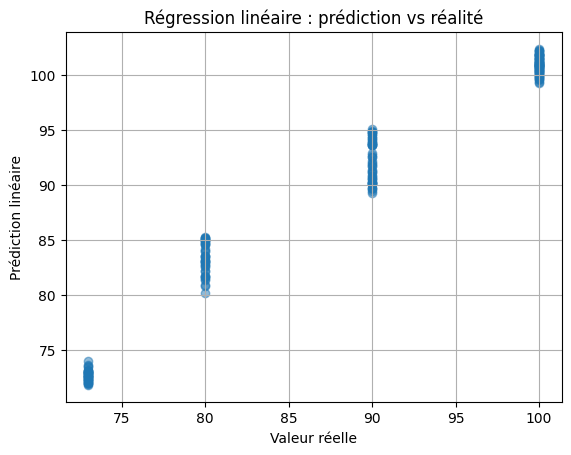

In [7]:

pressure_features = dataframe_to_features("pressure",pressure)
flow_feature = dataframe_to_features("flow",flow)
X = pd.concat([pressure_features, flow_feature], axis=1)

y = valve_condition


n_train = 2000
X_train = X.iloc[:n_train]
X_test = X.iloc[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE :", mean_squared_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeur réelle")
plt.ylabel("Prédiction linéaire")
plt.title("Régression linéaire : prédiction vs réalité")
plt.grid(True)
plt.show()

3) Deep learning (1D CNN)
Le modèle le plus adapté à ce type de problème est le réseau de neurones convolutionnel unidimensionnel (1D CNN). Ce type de modèle est capable d’apprendre automatiquement des motifs locaux dans les séries temporelles, ce qui le rend particulièrement pertinent pour la classification de signaux.

Contrairement aux modèles classiques, le 1D CNN est nettement moins sensible aux décalages temporels, car il apprend à détecter des motifs caractéristiques quelle que soit leur position dans la séquence. Cela en fait une approche robuste et performante pour ce type de données.

cpu
Epoch 1/15 - Train loss: 1.218675087928772 - Test loss: 1.4461720527672186
Epoch 2/15 - Train loss: 1.1886396484375 - Test loss: 1.4143492785895744
Epoch 3/15 - Train loss: 1.1572877721786499 - Test loss: 1.3802004841769613
Epoch 4/15 - Train loss: 1.0149336614608764 - Test loss: 1.0181078205748302
Epoch 5/15 - Train loss: 0.5619057605266571 - Test loss: 0.40939471180119164
Epoch 6/15 - Train loss: 0.25777296459674837 - Test loss: 0.2048699520346595
Epoch 7/15 - Train loss: 0.15542091894149782 - Test loss: 0.10009171743763656
Epoch 8/15 - Train loss: 0.09093650841712951 - Test loss: 0.052987049474585345
Epoch 9/15 - Train loss: 0.05596102148294449 - Test loss: 0.024201909863821616
Epoch 10/15 - Train loss: 0.037474337965250015 - Test loss: 0.015276356164093424
Epoch 11/15 - Train loss: 0.027807861026376487 - Test loss: 0.0093104311219621
Epoch 12/15 - Train loss: 0.020582285061478616 - Test loss: 0.0076528607322493706
Epoch 13/15 - Train loss: 0.01784627889096737 - Test loss: 0.007

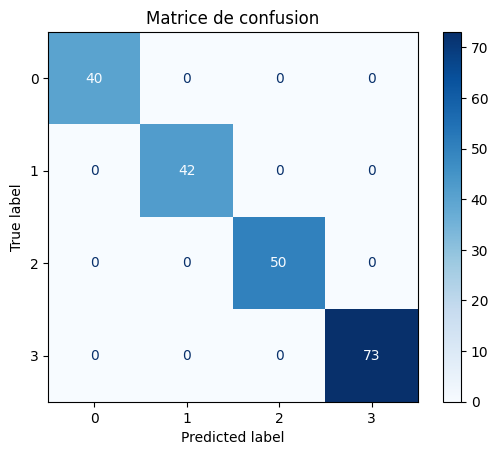

In [ ]:

class ValveDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        unique = sorted(np.unique(y))
        self.y = torch.tensor([unique.index(v) for v in y], dtype=torch.long)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.y[idx]


class ValveCNN(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 16, kernel_size=15, stride=3)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=9, stride=3)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=3)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, n_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x


def interpolate(number_points_flow, number_points_pressure, flow_individual):
    """give the same lenght to both vectors by interpolating"""
    x_old = np.linspace(0, 1, number_points_flow)
    x_new = np.linspace(0, 1, number_points_pressure)
    return np.interp(x_new, x_old, flow_individual)

pressure = pd.read_table('valve-condition-server/data/PS2.txt', header=None).values
flow = pd.read_table('valve-condition-server/data/FS1.txt', header = None).values
profile = pd.read_table('valve-condition-server/data/profile.txt', header = None)

valve_condition = profile.iloc[:, 1].values



# Interpolation de FS1
number_rows, number_points_pressure = pressure.shape
_, number_points_flow = flow.shape
flow_interpolated = np.zeros_like(pressure)
for i in range(number_rows):
    flow_interpolated[i] = interpolate(number_points_flow, number_points_pressure, flow[i])


X = np.stack([pressure, flow_interpolated], axis=1)
y = valve_condition

# Normalisation
X = (X - X.mean(axis=(0,2), keepdims=True)) / (X.std(axis=(0,2), keepdims=True))
n_train = 2000
X_train = X[:n_train]
X_test = X[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]

train_dataset = ValveDataset(X_train, y_train)
test_dataset = ValveDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = ValveCNN(n_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epoch = 15

train_losses = []
test_losses = []
for epoch in range(num_epoch):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()* Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            running_loss += loss.item() * Xb.size(0)
    test_loss = running_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch +1}/{num_epoch} - Train loss: {train_loss} - Test loss: {test_loss}")



all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        outputs = model(Xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = yb.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

Nous observons également de très bons résultats avec cette approche. Nous choisissons donc d’utiliser un modèle 1D CNN, car il s’agit probablement de la solution offrant la meilleure robustesse face aux variations temporelles des données.